In [2]:
import tensorflow as tf

import keras

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/home/anton/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [3]:
from keras.layers import Input, LSTM, RepeatVector, Dense, Embedding, Activation, Masking,SimpleRNN
from keras.models import Model, Sequential
from keras import backend as K

In [4]:
from functools import reduce
from tqdm import tqdm

### Spacers data

In [5]:
VOC_SIZE = 7
mask_val = 6

In [6]:
with open("./data/CRISPR_db_2109.txt") as f:
    lines = f.readlines()

In [7]:
lines = [x.split("\t")[1:] for x in lines]

lines = [[y for y in x if len(y) < 100 and len(y) > 5] for x in lines]

lines = reduce(lambda a,b: a+b, lines)

In [8]:
max_len = max([len(x) for x in lines])

In [9]:
max_len

67

In [10]:
l_to_n = dict()
l_to_n["A"] = 1
l_to_n["C"] = 2
l_to_n["T"] = 3
l_to_n["G"] = 4

letters = set(["A", "C", "T", "G"])

In [11]:
total_missed = 0

def process_spacer(spacer):
    spacer_as_array = np.ones(max_len + 2)*mask_val
    spacer_as_array[0] = 0
    for i, el in enumerate(spacer):
        if el in letters:
            spacer_as_array[i + 1] = l_to_n[el]
        else:
            spacer_as_array[i + 1] = mask_val
        
    spacer_as_array[len(spacer) + 1] = 5
    return spacer_as_array

In [12]:
process_spacer("AGTGCTGGACCATTTCAAATTCACAATAGATT")

array([ 0.,  1.,  4.,  3.,  4.,  2.,  3.,  4.,  4.,  1.,  2.,  2.,  1.,
        3.,  3.,  3.,  2.,  1.,  1.,  1.,  3.,  3.,  2.,  1.,  2.,  1.,
        1.,  3.,  1.,  4.,  1.,  3.,  3.,  5.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.])

In [13]:
X = np.empty((len(lines), max_len + 2))

for i, l in enumerate(lines):
    try:
        X[i] = process_spacer(l)
    except:
        print(l)
        
X = X.astype(int)

In [14]:
Y = np.zeros((X.shape[0], X.shape[1], VOC_SIZE))
mask_Y = np.zeros((X.shape[0], X.shape[1], VOC_SIZE))

In [15]:
for i in tqdm(range(X.shape[0])):
    for j in range(X.shape[1]):
        Y[i,j,X[i,j]] = 1
        if X[i,j] != mask_val:
            mask_Y[i,j,:] = 1

100%|██████████| 24809/24809 [00:03<00:00, 6622.93it/s]


In [16]:
Y.sum(0).sum(0)

array([  24809.,  189195.,  205033.,  199220.,  201330.,   24809.,  867425.])

In [110]:
mask_Y[0]

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,

#### Net

In [18]:
internal_dim = 10
out_dim = 20


In [19]:
encoder_input = Input(shape=(None,))

#encoder_mask_layer = Masking(mask_value=6, input_shape=(None,), name = 'enc_mask')
#encoder_mask = encoder_mask_layer(encoder_input)

encoder_embedding_layer = Embedding(VOC_SIZE, out_dim, name = 'enc_emb')
#encoder_embedding = encoder_embedding_layer(encoder_mask)
encoder_embedding = encoder_embedding_layer(encoder_input)

encoder_recurent_layer_1 = LSTM(internal_dim, return_sequences=True, return_state=True, name = 'enc_lstm')
encoder_recurent_1, encoder_h, encoder_c = encoder_recurent_layer_1(encoder_embedding)

encoder_out_layer = Dense(VOC_SIZE, activation='softmax', name = 'enc_out')
encoder_out = encoder_out_layer (encoder_recurent_1)

In [20]:
encoder = Model(encoder_input, [encoder_h, encoder_c])

In [21]:
decoder_input = Input(shape=(None,))

#decoder_mask_layer = Masking(mask_value=6, name = 'dec_mask')
#decoder_mask = decoder_mask_layer(decoder_input)

#decoder_embedding = encoder_embedding_layer(decoder_mask)
decoder_embedding = encoder_embedding_layer(decoder_input)

decoder_recurent_layer_1 = LSTM(internal_dim,return_sequences=True,return_state=True, name = 'dec_lstm')
decoder_recurent_1, _, _  = decoder_recurent_layer_1(decoder_embedding, initial_state = [encoder_h, encoder_c])

decoder_out_layer = Dense(VOC_SIZE, activation='softmax', name = 'dec_out')
decoder_out = decoder_out_layer(decoder_recurent_1)

In [22]:
total_model = Model([encoder_input, decoder_input], decoder_out)

##### Learning

In [23]:
total_model.compile(optimizer='adam', loss='categorical_crossentropy', sample_weight_mode='temporal')

In [24]:
X_ = X[:2]
Y_ = Y[:2]
Y_mask_ = mask_Y[:2]

In [25]:
X_ = np.tile(X_, (100, 1))
Y_ = np.tile(Y_, (100, 1, 1))
Y_mask_ = np.tile(Y_mask_, (100, 1, 1))

In [67]:
learning_progress = total_model.fit([X_[:,:], X_[:,:-1]], Y_[:,1:,:],
                                    batch_size=20,
                                    epochs=50,
                                    validation_split=0,
                                   sample_weight = Y_mask_[:,:68,0])

Epoch 1/50
200/200 [==============================] - 1s 5ms/step - loss: 0.1212
Epoch 2/50
200/200 [==============================] - 1s 5ms/step - loss: 0.1204A: 0s - loss: 0.12
Epoch 3/50
200/200 [==============================] - 1s 5ms/step - loss: 0.1196
Epoch 4/50
200/200 [==============================] - 1s 5ms/step - loss: 0.1188
Epoch 5/50
200/200 [==============================] - 1s 5ms/step - loss: 0.1179
Epoch 6/50
200/200 [==============================] - 1s 5ms/step - loss: 0.1171
Epoch 7/50
200/200 [==============================] - 1s 5ms/step - loss: 0.1164
Epoch 8/50
200/200 [==============================] - 1s 5ms/step - loss: 0.1156
Epoch 9/50
200/200 [==============================] - 1s 5ms/step - loss: 0.1148
Epoch 10/50
200/200 [==============================] - 1s 5ms/step - loss: 0.1141
Epoch 11/50
200/200 [==============================] - 1s 5ms/step - loss: 0.1133
Epoch 12/50
200/200 [==============================] - 1s 5ms/step - loss: 0.1126
Epoch 1

##### Decoder forward model

In [68]:
initial_decoder_h = Input(shape=(internal_dim,))
initial_decoder_c = Input(shape=(internal_dim,))

decoder_recurent_out, decoder_h, decoder_c = decoder_recurent_layer_1(decoder_embedding,
                                                                      initial_state=[initial_decoder_h, initial_decoder_c])
decoder_true_out  = decoder_out_layer(decoder_recurent_out)

In [69]:
total_decoder = Model([decoder_input, initial_decoder_h, initial_decoder_c], decoder_true_out)

##### Generate

In [264]:
def generate(l, h, c, init):
    for i in range(l):
        pred = total_decoder.predict([init, h_, c_])
        n = np.argmax(pred)
        
        init = np.vstack((init, np.array([[n]])))
    
    return init

In [542]:
total_decoder.predict([np.array([0, 1, 2]), h_, c_])

array([[[ 0.13776796,  0.14730649,  0.1446784 ,  0.14291027,  0.14520672,
          0.13949569,  0.14263448]],

       [[ 0.07735577,  0.02050216,  0.37942412,  0.33782396,  0.0431568 ,
          0.08849864,  0.05323854]],

       [[ 0.01292603,  0.04417176,  0.00277204,  0.00814106,  0.91438687,
          0.01046215,  0.00714002]]], dtype=float32)

In [543]:
X_[0]

array([0, 1, 1, 2, 1, 3, 2, 4, 4, 1, 1, 1, 2, 4, 4, 2, 3, 3, 2, 4, 2, 4, 4,
       2, 4, 4, 2, 4, 4, 1, 3, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

##### Give it a try

In [70]:
h_, c_ = encoder.predict(X_[0])

In [71]:
out = total_decoder.predict([X[0], h_, c_])

In [94]:
out = total_model.predict([X_[:1, :],X_[:1, :] ])

In [80]:
from sklearn.metrics import log_loss

In [95]:
out.shape

(1, 69, 7)

In [97]:
log_loss(Y[0], out[0])

0.044491666749611143

In [59]:
out.shape

(10, 1, 7)

In [61]:
Y[0, 1:11].shape

(10, 7)

In [103]:
total_model.evaluate([X_[:, :-1],X_[:, :-1]], Y_[:, 1:],sample_weight = Y_mask_[:,:68,0])

200/200 [==============================] - 0s 587us/step


0.091350545585155485

In [107]:
total_model.evaluate([X_[:1, :32],X_[:1, :32]], Y_[:1, 1:33])

1/1 [==============================] - 0s 8ms/step


4.8760509490966797

In [106]:
(X_[0] < 6).sum()

32

In [196]:
from sklearn.manifold import TSNE

In [207]:
tsne = TSNE(verbose=100)

In [209]:
h_tsne = tsne.fit_transform(h_[:1000])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.004s...
[t-SNE] Computed neighbors for 1000 samples in 0.264s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.222s
[t-SNE] Iteration 50: error = 70.3297577, gradient norm = 0.2492784 (50 iterations in 6.609s)
[t-SNE] Iteration 100: error = 69.1808701, gradient norm = 0.2313368 (50 iterations in 6.916s)
[t-SNE] Iteration 150: error = 69.0861588, gradient norm = 0.2289604 (50 iterations in 7.494s)
[t-SNE] Iteration 200: error = 68.9731064, gradient norm = 0.2402125 (50 iterations in 7.264s)
[t-SNE] Iteration 250: error = 68.9547348, gradient norm = 0.2332281 (50 iterations in 6.645s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.954735
[t-SNE] Iteration 300: error = 0.9030064, gradient norm = 0.0010024 (50 iterations in 7.026s)
[t-SNE] Iteration 350: error = 0.8167560, gradient norm = 0.00036

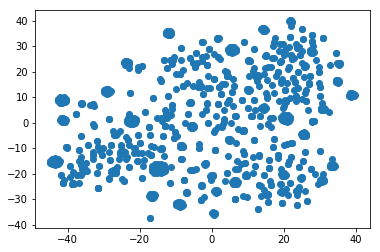

In [210]:
plt.scatter(h_tsne[:,0], h_tsne[:, 1])